In [12]:
import pandas as pd
import os
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import seaborn as sns

In [2]:
folder_path = '/Users/annele/PycharmProjects/Glas-O-Mat/data'
df_ContainerActivities_filtered = pd.read_csv(os.path.join(folder_path, 'modified_data/ContainerActivities_filtered.csv')) 
df_ContainerActivities_cleaned_coordinates = pd.read_csv(os.path.join(folder_path, 'modified_data/ContainerActivities_cleaned_coordinates.csv'))

/var/folders/hp/y7wgcxwd5s7ff9cjh270v5v40000gp/T/ipykernel_3779/2463326174.py:3: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ContainerActivities_cleaned_coordinates = pd.read_csv(os.path.join(folder_path, 'modified_data/ContainerActivities_cleaned_coordinates.csv'))


In [11]:
df_ContainerActivities_cleaned_coordinates

,Unnamed: 0,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,...,GEO_LAT,GEO_LON,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES
0,0,1,1001101101100271111,30,NaN,NaN,1001101101100271111/2023-09-28T06:36:48.022095...,TP1A.220624.014_2,2023-09-26 06:36:48.0,NaN,...,49.456130,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False
1,1,2,1001101101100271211,20,NaN,NaN,1001101101100271211/2023-09-28T06:36:05.355751...,TP1A.220624.014_2,2023-09-26 06:36:05.0,NaN,...,49.456130,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False
2,2,3,1001101101100271311,10,NaN,NaN,1001101101100271311/2023-09-28T06:37:16.029149...,TP1A.220624.014_2,2023-09-26 06:37:16.0,NaN,...,49.456130,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False
3,3,4,1001101101100191111,0,NaN,NaN,1001101101100191111/2023-09-28T06:51:15.117682...,TP1A.220624.014_2,2023-09-26 06:51:15.0,NaN,...,49.448608,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False
4,4,5,1001101101100191211,10,NaN,NaN,1001101101100191211/2023-09-28T06:51:43.824174...,TP1A.220624.014_2,2023-09-26 06:51:44.0,NaN,...,49.448608,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35525,35916,61150,1001101101100531112,90,NaN,NaN,1001101101100531112/2024-10-17T14:47:10.767846...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:11.0,NaN,...,49.440841,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True
35526,35917,61151,1001101101100531211,20,NaN,NaN,1001101101100531211/2024-10-17T14:46:43.691739...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:44.0,NaN,...,49.440841,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True
35527,35918,61152,1001101101100531212,90,NaN,NaN,1001101101100531212/2024-10-17T14:46:54.523517...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:55.0,NaN,...,49.440841,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True
35528,35919,61153,1001101101100531311,20,NaN,NaN,1001101101100531311/2024-10-17T14:47:19.611355...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:20.0,NaN,...,49.440841,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True


# Get population density

In [12]:
raster_path = "/Users/annele/Downloads/deu_pd_2020_1km.tif"

In [13]:
def calculate_population_density(lat, lon, raster_path, radius=1000):
    """
    Berechnet die durchschnittliche Bevölkerungsdichte für eine Koordinate im gegebenen Raster.
    
    Args:
        lat (float): Breitengrad.
        lon (float): Längengrad.
        raster_path (str): Pfad zu den Rasterdaten.
        radius (float): Radius in Metern (Standard: 100m).

    Returns:
        float: Durchschnittliche Bevölkerungsdichte im Umkreis.
    """
    # Punkt und Kreis erstellen
    point = Point(lon, lat)  # Reihenfolge: Lon, Lat
    circle = point.buffer(radius / 111_139)  # Umrechnen von Metern in Grad (1° ≈ 111,139 m)

    with rasterio.open(raster_path) as src:
        # Transformiere den Kreis ins Raster-CRS
        raster_crs = src.crs
        circle_gdf = gpd.GeoDataFrame({'geometry': [circle]}, crs="EPSG:4326")
        circle_transformed = circle_gdf.to_crs(raster_crs)
        circle = circle_transformed.geometry.iloc[0]

        # Zonal Stats berechnen
        stats = zonal_stats(circle, src.read(1), affine=src.transform, stats="mean", nodata=src.nodata)

        # Durchschnittliche Bevölkerungsdichte zurückgeben
        return stats[0]['mean']


In [14]:
# Berechnung der Bevölkerungsdichte für jede Zeile
df_ContainerActivities_cleaned_coordinates['POPULATION_DENSITY'] = df_ContainerActivities_cleaned_coordinates.apply(
    lambda row: calculate_population_density(row['NEW_LAT'], row['NEW_LON'], raster_path),
    axis=1
)
df_ContainerActivities_cleaned_coordinates

,Unnamed: 0,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,...,GEO_LON,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES,population_density
0,0,1,1001101101100271111,30,NaN,NaN,1001101101100271111/2023-09-28T06:36:48.022095...,TP1A.220624.014_2,2023-09-26 06:36:48.0,NaN,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
1,1,2,1001101101100271211,20,NaN,NaN,1001101101100271211/2023-09-28T06:36:05.355751...,TP1A.220624.014_2,2023-09-26 06:36:05.0,NaN,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
2,2,3,1001101101100271311,10,NaN,NaN,1001101101100271311/2023-09-28T06:37:16.029149...,TP1A.220624.014_2,2023-09-26 06:37:16.0,NaN,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
3,3,4,1001101101100191111,0,NaN,NaN,1001101101100191111/2023-09-28T06:51:15.117682...,TP1A.220624.014_2,2023-09-26 06:51:15.0,NaN,...,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862
4,4,5,1001101101100191211,10,NaN,NaN,1001101101100191211/2023-09-28T06:51:43.824174...,TP1A.220624.014_2,2023-09-26 06:51:44.0,NaN,...,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35525,35916,61150,1001101101100531112,90,NaN,NaN,1001101101100531112/2024-10-17T14:47:10.767846...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:11.0,NaN,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35526,35917,61151,1001101101100531211,20,NaN,NaN,1001101101100531211/2024-10-17T14:46:43.691739...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:44.0,NaN,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35527,35918,61152,1001101101100531212,90,NaN,NaN,1001101101100531212/2024-10-17T14:46:54.523517...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:55.0,NaN,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35528,35919,61153,1001101101100531311,20,NaN,NaN,1001101101100531311/2024-10-17T14:47:19.611355...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:20.0,NaN,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672


In [43]:
df_ContainerActivities_cleaned_coordinates.drop('Unnamed: 0', axis=1, inplace=True)
#df_ContainerActivities_cleaned_coordinates.drop('Unnamed: 0.1', axis=1, inplace=True)

In [44]:
df_ContainerActivities_cleaned_coordinates.to_csv('/Users/annele/PycharmProjects/Glas-O-Mat/data/modified_data/ContainerActivities_populations_density.csv')

In [62]:
df_ContainerActivities_cleaned_coordinates = pd.read_csv('/Users/annele/PycharmProjects/Glas-O-Mat/data/modified_data/ContainerActivities_populations_density.csv')
df_ContainerActivities_cleaned_coordinates.reset_index(drop=True, inplace=True)
df_ContainerActivities_cleaned_coordinates.drop('Unnamed: 0', axis=1, inplace=True)

df_ContainerActivities_cleaned_coordinates

/var/folders/hp/y7wgcxwd5s7ff9cjh270v5v40000gp/T/ipykernel_3779/290288042.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ContainerActivities_cleaned_coordinates = pd.read_csv('/Users/annele/PycharmProjects/Glas-O-Mat/data/modified_data/ContainerActivities_populations_density.csv')


,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,IS_EMPTIED,...,GEO_LON,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES,population_density
0,1,1001101101100271111,30,NaN,NaN,1001101101100271111/2023-09-28T06:36:48.022095...,TP1A.220624.014_2,2023-09-26 06:36:48.0,NaN,1,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
1,2,1001101101100271211,20,NaN,NaN,1001101101100271211/2023-09-28T06:36:05.355751...,TP1A.220624.014_2,2023-09-26 06:36:05.0,NaN,1,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
2,3,1001101101100271311,10,NaN,NaN,1001101101100271311/2023-09-28T06:37:16.029149...,TP1A.220624.014_2,2023-09-26 06:37:16.0,NaN,0,...,7.791667,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538
3,4,1001101101100191111,0,NaN,NaN,1001101101100191111/2023-09-28T06:51:15.117682...,TP1A.220624.014_2,2023-09-26 06:51:15.0,NaN,0,...,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862
4,5,1001101101100191211,10,NaN,NaN,1001101101100191211/2023-09-28T06:51:43.824174...,TP1A.220624.014_2,2023-09-26 06:51:44.0,NaN,0,...,7.769743,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35525,61150,1001101101100531112,90,NaN,NaN,1001101101100531112/2024-10-17T14:47:10.767846...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:11.0,NaN,1,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35526,61151,1001101101100531211,20,NaN,NaN,1001101101100531211/2024-10-17T14:46:43.691739...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:44.0,NaN,1,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35527,61152,1001101101100531212,90,NaN,NaN,1001101101100531212/2024-10-17T14:46:54.523517...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:55.0,NaN,1,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672
35528,61153,1001101101100531311,20,NaN,NaN,1001101101100531311/2024-10-17T14:47:19.611355...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:20.0,NaN,0,...,7.708089,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672


In [47]:
df_ContainerActivities_cleaned_coordinates[df_ContainerActivities_cleaned_coordinates['population_density'].isnull()]

,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,IS_EMPTIED,...,GEO_LON,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES,population_density


In [48]:
df_ContainerActivities_cleaned_coordinates.sort_values(by=['LOCATION_ID','CONTAINER_ID' ,'DATE'], inplace=True)
df_ContainerActivities_cleaned_coordinates

,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,IS_EMPTIED,...,GEO_LON,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES,population_density
135,217,1001101101100011111,50,NaN,NaN,1001101101100011111/2023-09-29T09:34:59.668033...,TP1A.220624.014_2,2023-09-27 09:35:00.0,NaN,1,...,7.726918,2023-09-27,accurate,False,18.344643,49.404778,7.726918,0.000000,False,503.742798
615,1175,1001101101100011111,40,NaN,NaN,1001101101100011111/2023-10-07T09:24:26.821226...,TP1A.220624.014_2,2023-10-05 09:24:27.0,NaN,1,...,7.726918,2023-10-05,accurate,False,17.887946,49.404778,7.726918,0.000000,False,503.742798
1147,2353,1001101101100011111,50,NaN,NaN,1001101101100011111/2023-10-13T10:04:28.407116...,TP1A.220624.014_2,2023-10-11 10:04:28.0,NaN,1,...,7.726918,2023-10-11,accurate,False,14.514515,49.404778,7.726918,0.000000,False,503.742798
1729,3514,1001101101100011111,70,NaN,NaN,1001101101100011111/2023-10-19T10:16:42.772468...,TP1A.220624.014_2,2023-10-17 10:16:43.0,NaN,1,...,7.726918,2023-10-17,accurate,False,13.346898,49.404778,7.726918,0.000000,False,503.742798
2248,4515,1001101101100011111,80,NaN,NaN,1001101101100011111/2023-10-26T13:03:24.838577...,TP1A.220624.014_2,2023-10-24 13:03:25.0,NaN,1,...,7.726918,2023-10-24,accurate,False,17.479400,49.404778,7.726918,0.000000,False,503.742798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34805,60430,1001101102101301211,0,NaN,NaN,1001101102101301211/2024-10-10T08:56:21.991198...,TP1A.220624.014_9ce1a15a4bdc6fe5,2024-10-10 08:56:22.0,NaN,0,...,7.531113,2024-10-10,NaN,NaN,NaN,49.437512,7.531113,0.000000,True,290.656169
35437,61062,1001101102101301211,0,NaN,NaN,1001101102101301211/2024-10-17T09:12:10.945904...,TP1A.220624.014_9ce1a15a4bdc6fe5,2024-10-17 09:12:11.0,NaN,0,...,7.531113,2024-10-17,NaN,NaN,NaN,49.437512,7.531113,0.000000,True,290.656169
20742,28564,1001101102101301311,70,NaN,NaN,1001101102101301311/2024-05-10T10:31:15.318240...,UP1A.231005.007_6695359986a10fa0,2024-05-10 10:31:15.0,NaN,1,...,7.531113,2024-05-10,temporary_shift,False,33.110015,49.437560,7.528855,163.867643,False,260.557770
26710,50595,1001101102101301311,20,NaN,NaN,1001101102101301311/2024-07-12T09:38:57.241099...,TP1A.220624.014_4ac8e8be5475e6a6,2024-07-12 09:38:57.0,NaN,0,...,7.531113,2024-07-12,temporary_shift,True,1967.207629,49.437560,7.528855,163.867643,False,260.557770


In [7]:
df_ContainerActivities_cleaned_coordinates = df_ContainerActivities_cleaned_coordinates[['LOCATION_ID', 'CONTAINER_ID', 'DATE', 'SLIDER_LEVEL', 'IS_EMPTIED', 'population_density']]
df_ContainerActivities_cleaned_coordinates

,LOCATION_ID,CONTAINER_ID,DATE,SLIDER_LEVEL,IS_EMPTIED,population_density
135,100110110110001,1001101101100011111,2023-09-27,50,1,503.742798
615,100110110110001,1001101101100011111,2023-10-05,40,1,503.742798
1147,100110110110001,1001101101100011111,2023-10-11,50,1,503.742798
1729,100110110110001,1001101101100011111,2023-10-17,70,1,503.742798
2248,100110110110001,1001101101100011111,2023-10-24,80,1,503.742798
...,...,...,...,...,...,...
34805,100110110210130,1001101102101301211,2024-10-10,0,0,290.656169
35437,100110110210130,1001101102101301211,2024-10-17,0,0,290.656169
20742,100110110210130,1001101102101301311,2024-05-10,70,1,260.557770
26710,100110110210130,1001101102101301311,2024-07-12,20,0,260.557770


# Get Fill Level Growth

In [76]:
# Sicherstellen, dass DATE als Datentyp datetime ist
df_ContainerActivities_cleaned_coordinates['DATE'] = pd.to_datetime(df_ContainerActivities_cleaned_coordinates['DATE'])

# Sortieren nach LOCATION_ID, CONTAINER_ID und DATE
df = df_ContainerActivities_cleaned_coordinates.sort_values(by=['LOCATION_ID', 'CONTAINER_ID', 'DATE'])

# Berechnung der Füllrate
def calculate_fill_rate(group):
    # Kopie des Levels erstellen, um Anpassungen vorzunehmen
    group['SLIDER_LEVEL_temp'] = group['SLIDER_LEVEL'].copy()
    slider_level = group['SLIDER_LEVEL'].copy()
    slider_level_temp = group['SLIDER_LEVEL_temp'].copy()
    
    # Wenn der Container geleert wurde, setze den Slider-Level des Vortages auf 0
    slider_level_temp = slider_level_temp.where(group['IS_EMPTIED'] != 1, 0)

    # Differenz des Levels berechnen (aktueller Tag - vorheriger Tag)
    group['FILL_RATE'] = slider_level - slider_level_temp.shift(1)

    # Der erste Wert jeder Gruppe hat keine Füllrate
    group['FILL_RATE'].iloc[0] = None
    return group

# Gruppieren und die Füllrate berechnen
df_ContainerActivities_cleaned_coordinates = df_ContainerActivities_cleaned_coordinates.groupby(['LOCATION_ID', 'CONTAINER_ID'], group_keys=False).apply(calculate_fill_rate)

df_ContainerActivities_cleaned_coordinates.drop('SLIDER_LEVEL_temp', axis=1, inplace=True)

df_ContainerActivities_cleaned_coordinates

/var/folders/hp/y7wgcxwd5s7ff9cjh270v5v40000gp/T/ipykernel_3779/731545866.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group['FILL_RATE'].iloc[0] = None
/var/folders/hp/y7wgcxwd5s7ff9cjh270v5v40000gp/T/ipykernel_3779/731545866.py:21:

,TRANSACTION_ID,CONTAINER_ID,SLIDER_LEVEL,CV_LEVEL,SENSOR_LEVEL,IMAGE_ID,PHONE_ID,RECORDED_AT,COMMENT,IS_EMPTIED,...,DATE,CLASSIFICATION,outlier,DISTANCE,NEW_LAT,NEW_LON,NEW_DISTANCE,INACCURATE_COORDINATES,population_density,FILL_RATE
0,1,1001101101100271111,30,NaN,NaN,1001101101100271111/2023-09-28T06:36:48.022095...,TP1A.220624.014_2,2023-09-26 06:36:48.0,NaN,1,...,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538,NaN
1,2,1001101101100271211,20,NaN,NaN,1001101101100271211/2023-09-28T06:36:05.355751...,TP1A.220624.014_2,2023-09-26 06:36:05.0,NaN,1,...,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538,NaN
2,3,1001101101100271311,10,NaN,NaN,1001101101100271311/2023-09-28T06:37:16.029149...,TP1A.220624.014_2,2023-09-26 06:37:16.0,NaN,0,...,2023-09-26,accurate,False,20.382686,49.456130,7.791667,0.0,False,1248.576538,NaN
3,4,1001101101100191111,0,NaN,NaN,1001101101100191111/2023-09-28T06:51:15.117682...,TP1A.220624.014_2,2023-09-26 06:51:15.0,NaN,0,...,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862,NaN
4,5,1001101101100191211,10,NaN,NaN,1001101101100191211/2023-09-28T06:51:43.824174...,TP1A.220624.014_2,2023-09-26 06:51:44.0,NaN,0,...,2023-09-26,accurate,False,8.700529,49.448608,7.769743,0.0,False,2236.116862,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35525,61150,1001101101100531112,90,NaN,NaN,1001101101100531112/2024-10-17T14:47:10.767846...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:11.0,NaN,1,...,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672,20.0
35526,61151,1001101101100531211,20,NaN,NaN,1001101101100531211/2024-10-17T14:46:43.691739...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:44.0,NaN,1,...,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672,-50.0
35527,61152,1001101101100531212,90,NaN,NaN,1001101101100531212/2024-10-17T14:46:54.523517...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:46:55.0,NaN,1,...,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672,60.0
35528,61153,1001101101100531311,20,NaN,NaN,1001101101100531311/2024-10-17T14:47:19.611355...,UP1A.231005.007_0a1ae090352d8dcc,2024-10-17 14:47:20.0,NaN,0,...,2024-10-17,NaN,NaN,NaN,49.440841,7.708089,0.0,True,1878.638672,20.0


# Feature Analysis

Erklärte Varianz der Hauptkomponenten: [0.58077674 0.41922326]


/var/folders/hp/y7wgcxwd5s7ff9cjh270v5v40000gp/T/ipykernel_3779/3596743892.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, cmap='viridis')


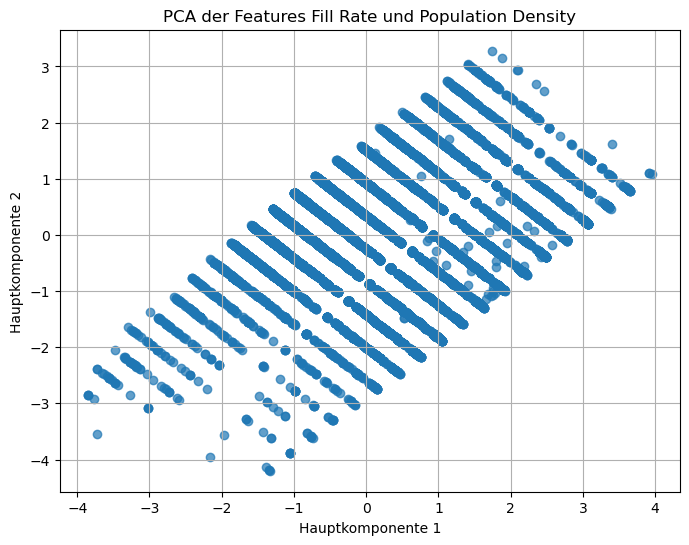

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Relevante numerische Features auswählen
features = ['FILL_RATE', 'population_density']
X = df_ContainerActivities_cleaned_coordinates[features]

# 2. NaN-Werte entfernen
X = X.dropna()

# 3. Daten skalieren (Standardisierung)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA durchführen
pca = PCA(n_components=2)  # Reduzierung auf 2 Hauptkomponenten
X_pca = pca.fit_transform(X_scaled)

# 5. Ergebnisse analysieren
explained_variance_ratio = pca.explained_variance_ratio_

print("Erklärte Varianz der Hauptkomponenten:", explained_variance_ratio)

# 6. Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, cmap='viridis')
plt.title('PCA der Features Fill Rate und Population Density')
plt.xlabel('Hauptkomponente 1')
plt.ylabel('Hauptkomponente 2')
plt.grid()
plt.show()

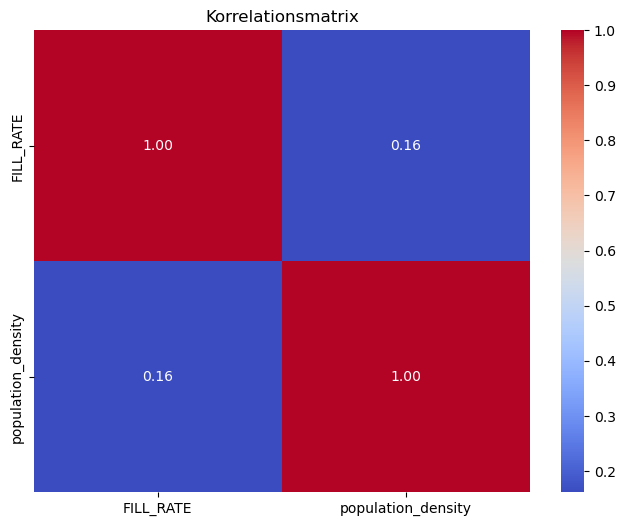

In [78]:
correlation_matrix = df_ContainerActivities_cleaned_coordinates[features].corr()
# pearson correlation coefficient
# spearman
# supermarkt schauen welcher kooefizient passt
# Korrelationsmatrix visualisieren
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix")
plt.show()